## Data loading and preprocessing


In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm as tq

## Load the resources
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')


stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# If using the colab uncomment the below lines
# from google.colab import files
# src = list(files.upload().values())[0]
# open('cluster_evaluate.py','wb').write(src)
from cluster_evaluate import *

Saving cluster_evaluate.py to cluster_evaluate (1).py
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Data loading and preparation**


In [ ]:
def book_pagination(book, book_name, author, title):
    """
    Partitioning(pagination) of the book to take each 100 word with the label/book_name for each partition.
    """
    tokenized_words=nltk.word_tokenize(book)
    tokenized_words = [w for w in tokenized_words if not w.lower() in stop_words]
    offset = 0
    pages = []
    for i in range(1, min(int(np.floor(len(tokenized_words)/150.0)), 200)):
        limit = i*150
        pages.append({'book_name': book_name,
                      'partition': " ".join(tokenized_words[offset:limit]),
                      'author': author,
                      'title': title})
        offset = limit 
    return pages

def clean_text(text):
  ## 1. Lowercase the text
  text = text.lower() 

  ## 2. Remove Punctuations
  text = text.translate(str.maketrans('', '', string.punctuation)) 
  
  ## 3. Tokenize all the words
  words = nltk.word_tokenize(text)

  ## 4. Remove stopwords and word digits
  clean_text = " ".join([ w for w in words if w.isalnum() ])
  clean_text = clean_text.replace("\t", ' ')
  # clean_text = " ".join([ w for w in words if w.isalnum() and (w not in stop_words)  ])
  return clean_text

## Book Selection

In [ ]:
import json

In [ ]:
books = [
         {'file': 'austen-emma.txt' , 'url': "https://www.gutenberg.org/ebooks/158",
          'author': 'Jane Austen', 'genre': 'Fiction', 'title': 'Emma'},
         
         {'file': 'blake-poems.txt', 'url':'https://www.gutenberg.org/ebooks/574',
          'author': 'William Blake', 'genre': 'Poetry', 'title': 'Poems of William Blake'},
         
         {'file': 'shakespeare-hamlet.txt', 'url':'https://www.gutenberg.org/ebooks/1787',
          'author': 'William Shakespeare', 'genre': 'Drama', 'title': 'Hamlet'},
         
         {'file': 'carroll-alice.txt', 'url':'https://www.gutenberg.org/ebooks/35688',
         'author': 'Lewis Carroll and Alice Gerstenberg', 'genre': 'Fantasy Drama', 'title': 'Alice in Wonderland'},
         
         {'file': 'edgeworth-parents.txt', 'url':'https://www.gutenberg.org/ebooks/36132',
          'author': 'Maria Edgeworth', 'genre': "Children's stories", 'title': "The Parent's Assistant; Or, Stories for Children"}]

with open('books.json', 'w') as jf:
  json.dump(books, jf)

### Load the books & prepare partitions

In [ ]:
books = pd.read_json('books.json')

In [ ]:
book_pages = []
for ind,bk in tq(books.iterrows(), total=books.shape[0]):
    book = nltk.corpus.gutenberg.raw(bk['file'])
    clean_book = clean_text(book) ## Regex to clean the text and tokenize it
    mydict=book_pagination(clean_book, bk['file'].split('.txt')[0], bk['author'], bk['title'])
    book_pages+=mydict

books_df = pd.DataFrame(book_pages)

100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


In [ ]:
books_df

,book_name,partition,author,title
0,austen-emma,emma jane austen 1816 volume chapter emma wood...,Jane Austen,Emma
1,austen-emma,liked highly esteeming miss taylors judgment d...,Jane Austen,Emma
2,austen-emma,promoted match black mornings work want miss t...,Jane Austen,Emma
3,austen-emma,mile miss taylor house advantages natural dome...,Jane Austen,Emma
4,austen-emma,lawn shrubberies name really belong afforded e...,Jane Austen,Emma
...,...,...,...,...
711,edgeworth-parents,seem good wont take amiss miss somers sister s...,Maria Edgeworth,"The Parent's Assistant; Or, Stories for Children"
712,edgeworth-parents,friend rose looked much satisfied speech compl...,Maria Edgeworth,"The Parent's Assistant; Or, Stories for Children"
713,edgeworth-parents,sister roughly charitable class like things wh...,Maria Edgeworth,"The Parent's Assistant; Or, Stories for Children"
714,edgeworth-parents,susan entirely liberty detain longer good nigh...,Maria Edgeworth,"The Parent's Assistant; Or, Stories for Children"


### LDA Model

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import gensim.corpora as corpora

In [ ]:
lines_words = [nltk.word_tokenize(parition) for parition in books_df.partition.values]

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(lines_words)

# Create Corpus
texts = lines_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(lines_words)
common_corpus = [common_dictionary.doc2bow(text) for text in lines_words]

# Train the model on the corpus.
lda_model = LdaModel(corpus=corpus,
                       id2word=id2word,
                       num_topics=5,
                       random_state=100,
                       update_every=1,
                       chunksize=100,
                       passes=10,
                       alpha='auto',
                       per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
doc_lda = lda_model[corpus]
lda_model.print_topics()

[(0,
  '0.028*"susan" + 0.011*"harper" + 0.008*"rose" + 0.008*"william" + 0.008*"little" + 0.007*"voices" + 0.007*"blind" + 0.006*"thy" + 0.006*"old" + 0.006*"lamb"'),
 (1,
  '0.015*"susan" + 0.011*"good" + 0.010*"miss" + 0.008*"upon" + 0.008*"somers" + 0.007*"sir" + 0.007*"would" + 0.007*"mr" + 0.007*"us" + 0.006*"maam"'),
 (2,
  '0.037*"said" + 0.013*"little" + 0.009*"alice" + 0.009*"one" + 0.009*"know" + 0.008*"could" + 0.007*"would" + 0.007*"went" + 0.007*"see" + 0.006*"much"'),
 (3,
  '0.009*"miss" + 0.008*"susan" + 0.007*"somers" + 0.007*"harp" + 0.006*"answered" + 0.006*"standing" + 0.005*"simple" + 0.004*"grew" + 0.004*"blush" + 0.004*"bumper"'),
 (4,
  '0.018*"ham" + 0.011*"lord" + 0.010*"king" + 0.009*"haue" + 0.007*"hamlet" + 0.006*"good" + 0.006*"come" + 0.005*"shall" + 0.005*"let" + 0.005*"thou"')]

## Visualize the topics

In [ ]:
# If not installed 
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
# Plotting tools
import pyLDAvis
from pyLDAvis import gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.238631 -0.096200       1        1  45.455429
1     -0.120652  0.180971       2        1  21.664633
4      0.080248 -0.099475       3        1  19.824078
0      0.116270 -0.096088       4        1   8.881599
3      0.162765  0.110793       5        1   4.174260, topic_info=          Term         Freq        Total Category  logprob  loglift
399       said  1211.000000  1211.000000  Default  30.0000  30.0000
4477     susan   434.000000   434.000000  Default  29.0000  29.0000
5481       ham   257.000000   257.000000  Default  28.0000  28.0000
44      little   476.000000   476.000000  Default  27.0000  27.0000
50        miss   198.000000   198.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3033    pushed     8.320439    15.366769   Topic5  -5.8839   2.5627
28      father    10.224745   120.653835   Topic5  -5.6778   0.7081
394        pay     8.855818    42.749129   Topic5  -5.8215   1.6020
11369   harper     9.156199    89.124952   Topic5  -5.7882   0.9006
1251   harriet     8.602657    38.635298   Topic5  -5.8505   1.6741

[309 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1081      2  0.965964    abbey
1829      1  0.992206    added
1272      2  0.110334  admired
1272      5  0.772336  admired
511       1  0.946945   afraid
...     ...       ...      ...
5927      1  0.986978     wont
242       1  0.609794    would
242       2  0.268208    would
242       3  0.121453    would
83        2  0.970048    years

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

## Evaluate Clusters

In [ ]:
def get_doc_topics(doc_bow,
                   doc_id,
                   threshold=0.3,
                   best_topic=False):
  
  topics = lda_model.get_document_topics(doc_bow) ## soft assignments of topics
  sorted_topics = sorted(topics,  reverse=True, key=lambda x: x[1])
  
  if threshold and not best_topic: ## return best topic assignment based on specified threshold
    return [{'topic': topic[0], 'soft_assignment': topic[1], 'doc_id': doc_id} for topic in sorted_topics if topic[1]> threshold]
  
  elif best_topic: ## return just the top topic assignment
    return {'topic': sorted_topics[0][0], 'soft_assignment': sorted_topics[0][1], 'doc_id': doc_id}
  
  else: ## return all the topic assignments
    return [{'topic': topic[0], 'soft_assignment': topic[1], 'doc_id': doc_id} for topic in sorted_topics]

  # return sorted(topics,  reverse=True, key=lambda x: x[1]) ## return all topic_assignments

In [ ]:
doc_all_topics = [get_doc_topics(doc_bow, doc_id=i, threshold=None, best_topic=False) for i, doc_bow in enumerate(common_corpus)]

In [ ]:
doc_best_topics = pd.DataFrame([get_doc_topics(doc_bow, doc_id=i, threshold=None, best_topic=True) for i, doc_bow in enumerate(common_corpus)])

In [ ]:
## Extract the threshold from the documents best topic assignments
threshold = (doc_best_topics.soft_assignment.mean() + doc_best_topics.soft_assignment.median())/2
print(threshold)

## Get more topics assignments for each topic based on the above threshold
doc_topics_threshold = [get_doc_topics(doc_bow, doc_id=i, threshold=threshold) for i, doc_bow in enumerate(common_corpus)]

0.7264998051124578


### Performance Evaluation

In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

bow_vec = CountVectorizer(stop_words={"english"}) ## LDA uses the BOW features
bow = bow_vec.fit_transform(books_df.partition.values)


In [ ]:
labels_lda = map_actual_labels(doc_best_topics.topic.values, books_df.author)

In [ ]:
calculate_metrics(books_df.author, labels_lda, bow)

Homogeneity score:  0.52
Completeness score:  0.67
V-measure score:  0.59
Adjusted rand score:  0.38
Kappa score:  0.66
Silhouette score:  0.01
Correlation:  SpearmanrResult(correlation=0.7508590971944392, pvalue=9.342580150251219e-131)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:124: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:124: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

### Cluster labels vs Human labels 

In [ ]:
cluster_labels = get_clusters_label(cluster_predictions= doc_best_topics.topic.values,
                                    actual_labels = books_df.author)

In [ ]:
cluster_labels

actual_labels
clusters actual_labels                                     
0        William Blake                            87.804878
         Maria Edgeworth                           4.878049
         William Shakespeare                       4.878049
         Jane Austen                               2.439024
1        Maria Edgeworth                          66.242038
         Jane Austen                              33.757962
2        Jane Austen                              39.889197
         Lewis Carroll and Alice Gerstenberg      34.626039
         Maria Edgeworth                          25.484765
3        Jane Austen                              50.000000
         Maria Edgeworth                          50.000000
4        William Shakespeare                     100.000000

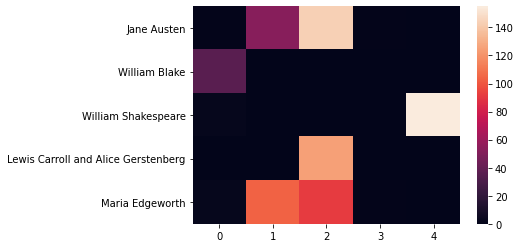

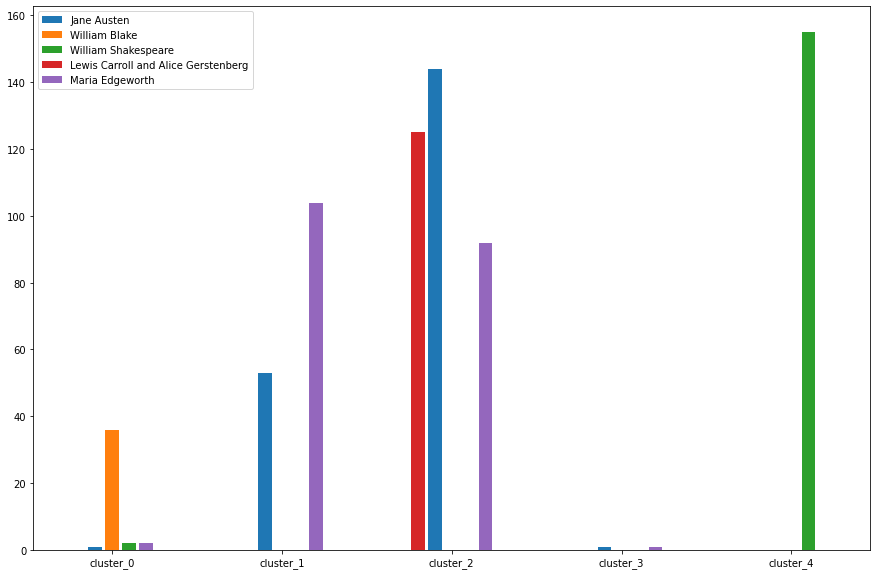

,0,1,2,3,4,label
0,1,53,144,1,0,Jane Austen
1,36,0,0,0,0,William Blake
2,2,0,0,0,155,William Shakespeare
3,0,0,125,0,0,Lewis Carroll and Alice Gerstenberg
4,2,104,92,1,0,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(cluster_predictions= doc_best_topics.topic.values,
                                                actual_labels = books_df.author)

### Error-analysis of Top frequent words in each cluster

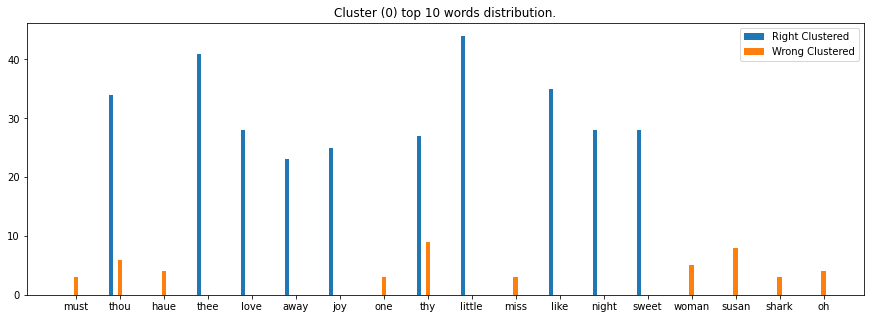

Top 10 words in the right clustered
 [('little', 44), ('thee', 41), ('like', 35), ('thou', 34), ('sweet', 28), ('love', 28), ('night', 28), ('thy', 27), ('joy', 25), ('away', 23)]

Top 10 words in the wrong clustered
 [('thy', 9), ('susan', 8), ('thou', 6), ('woman', 5), ('oh', 4), ('haue', 4), ('one', 3), ('shark', 3), ('must', 3), ('miss', 3)]

Found 2 words in both right and wrong clustered top words [('thy', 9), ('thou', 6)]




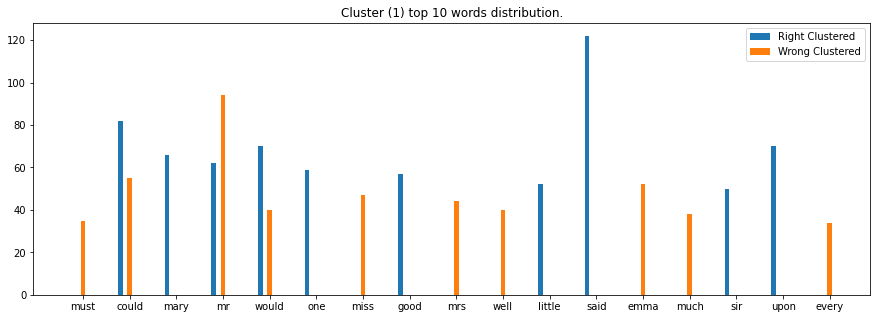

Top 10 words in the right clustered
 [('said', 122), ('could', 82), ('would', 70), ('upon', 70), ('mary', 66), ('mr', 62), ('one', 59), ('good', 57), ('little', 52), ('sir', 50)]

Top 10 words in the wrong clustered
 [('mr', 94), ('could', 55), ('emma', 52), ('miss', 47), ('mrs', 44), ('would', 40), ('well', 40), ('much', 38), ('must', 35), ('every', 34)]

Found 3 words in both right and wrong clustered top words [('mr', 94), ('could', 55), ('would', 40)]




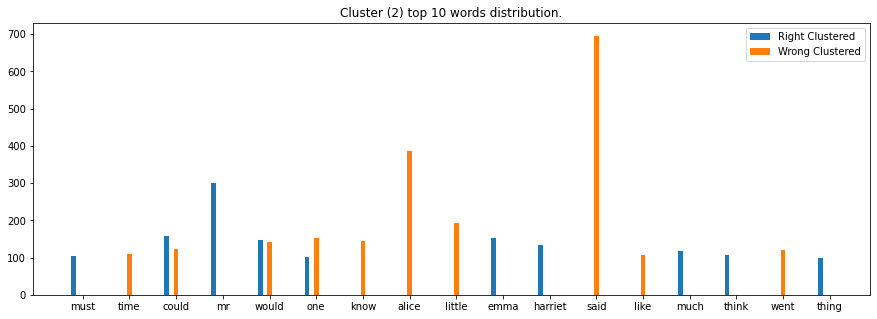

Top 10 words in the right clustered
 [('mr', 301), ('could', 157), ('emma', 152), ('would', 148), ('harriet', 134), ('much', 118), ('think', 106), ('must', 104), ('one', 102), ('thing', 99)]

Top 10 words in the wrong clustered
 [('said', 695), ('alice', 385), ('little', 193), ('one', 153), ('know', 144), ('would', 142), ('could', 124), ('went', 119), ('time', 109), ('like', 108)]

Found 3 words in both right and wrong clustered top words [('one', 153), ('would', 142), ('could', 124)]




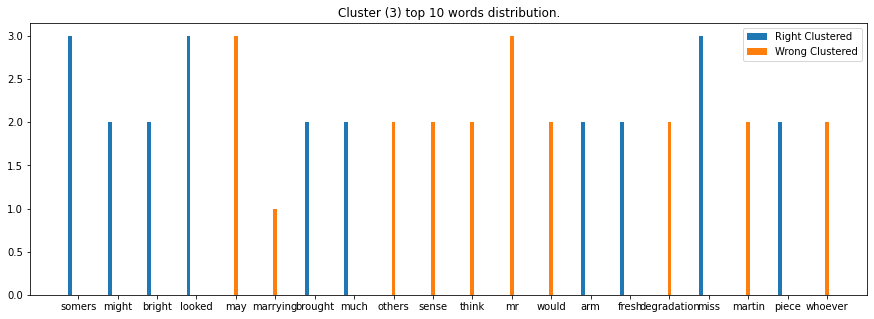

Top 10 words in the right clustered
 [('looked', 3), ('miss', 3), ('somers', 3), ('much', 2), ('might', 2), ('piece', 2), ('bright', 2), ('arm', 2), ('brought', 2), ('fresh', 2)]

Top 10 words in the wrong clustered
 [('mr', 3), ('may', 3), ('think', 2), ('would', 2), ('others', 2), ('martin', 2), ('degradation', 2), ('sense', 2), ('whoever', 2), ('marrying', 1)]

Found 0 words in both right and wrong clustered top words []




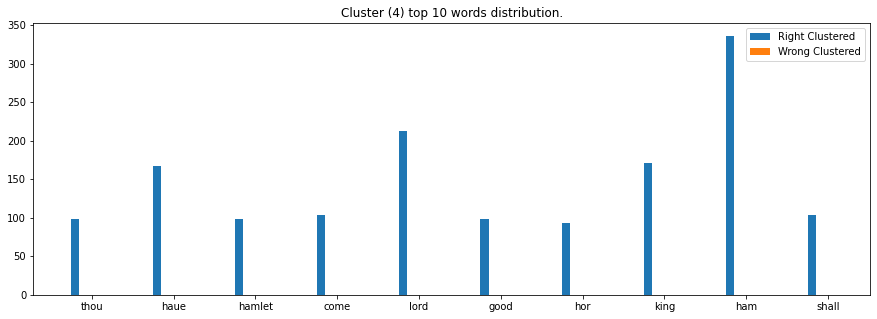

Top 10 words in the right clustered
 [('ham', 336), ('lord', 212), ('king', 171), ('haue', 167), ('come', 104), ('shall', 104), ('thou', 99), ('hamlet', 98), ('good', 98), ('hor', 93)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




In [ ]:
top_frequent_analysis(doc_best_topics.topic.values, books_df.author, books_df.partition, exclude_stopwords=True)